In [1]:
import deeplake
import matplotlib.pyplot as plt
import os
import cv2, numpy, vptree, PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms, models
import time
import tensorflow as tf
import faiss

/home/aaryan/miniconda3/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.0) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
2024-04-07 15:01:49.850066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 15:01:50.955883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def plot_image(img):
    if (len(img.shape) == 2):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [4]:
def plot_two(image1, image2):
    # Create a figure and axis objects
    fig, axes = plt.subplots(1, 2)
    
    # Plot the first image on the left axis
    axes[0].imshow(image1, cmap='gray')

    axes[0].set_title('Image 1')
    
    # Plot the second image on the right axis
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title('Image 2')
    
    # Hide axis ticks and labels
    for ax in axes:
        ax.axis('off')
    
    # Show the plot
    plt.show()


In [5]:
# turns image into the shape (x, x, 3)
def reorient_channels(img):
    if len(img.shape) == 2:
        return img
    if len(img.shape) != 3:
        raise Exception("Image does not have 2 or 3 channels")

    # color_channel = img.shape.index(3)
    channels = [-1, -1, -1]
    shape = img.shape
    for i in range(3):
        if shape[i] == 3:
            channels[2] = i
        else:
            idx = channels.index(-1)
            channels[idx] = i
            
    # print(channels)
    correct = tf.transpose(img, [channels[0], channels[1], channels[2]])
    return correct

In [6]:
edges = torch.load('edges.pt')
og = torch.load('og.pt')

2024-04-07 15:01:54.032800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 15:01:54.033950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 15:01:54.034095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
def canny(img, thresh1, thresh2):
    img_uint8 = (img.numpy() * 255).astype(np.uint8)
    return cv2.Canny(img_uint8, thresh1, thresh2)

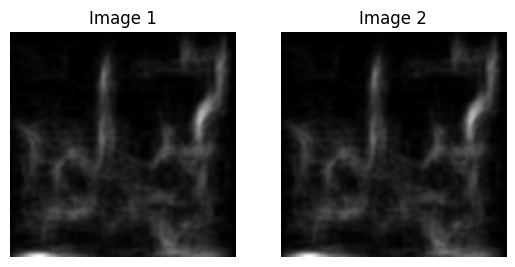

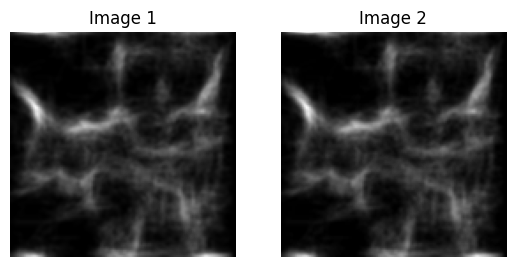

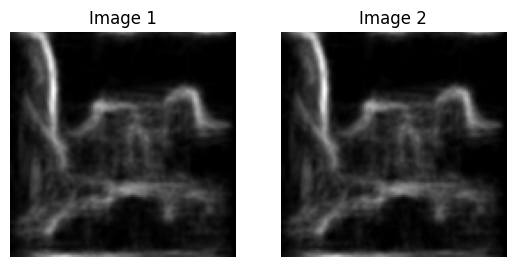

In [23]:
for i in range(3):
    val = 50
    # _, binary_image = cv2.threshold(edges[i].numpy(), 0.2, 1, cv2.THRESH_BINARY)
    # print(edges[i].numpy().shape)
    # th3 = cv2.adaptiveThreshold(edges[i].numpy(),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    scaled = (edges[i].numpy() * 255).astype('uint8')
    # plot_two(edges[i], canny(edges[i], val, 2 * val))
    plot_two(edges[i], scaled)

# for i in range(5):
#     plot_two(edges[i], reorient_channels(og[i]))